In [25]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/nathandrucker/opt/anaconda3/envs/ubermag/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cross']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Introduction

The goal of this notebook is to generate a SANS spectrum from a magnetization field. This method of generating data will form the basis of training data used in a neural network that predicts topological magnetic structures from SANS spectra.


References: https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004

# Create Field
https://github.com/ubermag/workshop/blob/f156aa75e501f2ad5e384a00f1776db9a7628869/tutorials/field-operations2.ipynb

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

1. Set up area of field
    - define cell
    - define region
    - define mesh

In [6]:
L = 400e-9
thickness = 5e-9
cell = (2.5e-9, 2.5e-9, 5e-9)
p1 = (-L/2, -L/2, 0)
p2 = (L/2, L/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc='xy')

2. Define Hamiltonian
    - define interactions to be included
    - define system
    - define energy

In [7]:
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
K = 1e4
u = (0, 0, 1)
H = (0, 0, 1e5)
system = mm.System(name='skyrmion')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T') + mm.Zeeman(H=H) + mm.UniaxialAnisotropy(K=K, u=u)

 3. Define magnetisation
    - start with random config 
    - optimize

Running OOMMF (ExeOOMMFRunner) [2020/07/29 15:50]... (82.6 s)


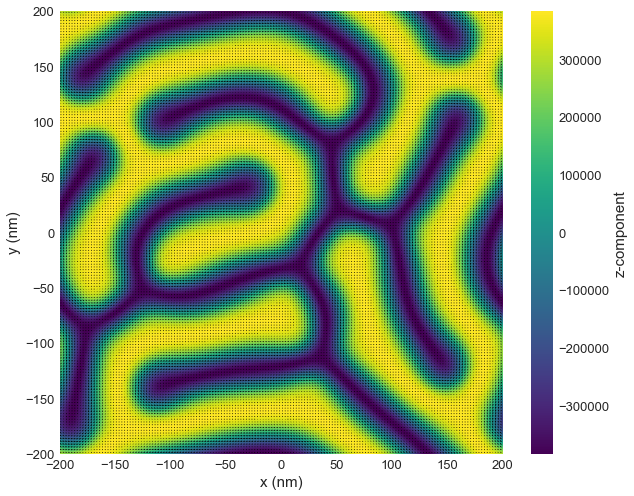

In [26]:
def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (L/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)

md = mc.MinDriver()
md.drive(system)

system.m.plane('z').mpl(figsize=(9, 7))
tight_layout()

In [183]:
foo=np.array(system.m)
foo

array(Field(mesh=Mesh(region=Region(p1=(-2e-07, -2e-07, 0.0), p2=(2e-07, 2e-07, 5e-09)), n=(160, 160, 1), bc='xy', subregions={}), dim=3),
      dtype=object)

In [54]:
def colorbar(mappable, title):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, extend='both',shrink=0.5)
    cbar.ax.set_ylabel(title)
    plt.sca(last_axes)
    return cbar

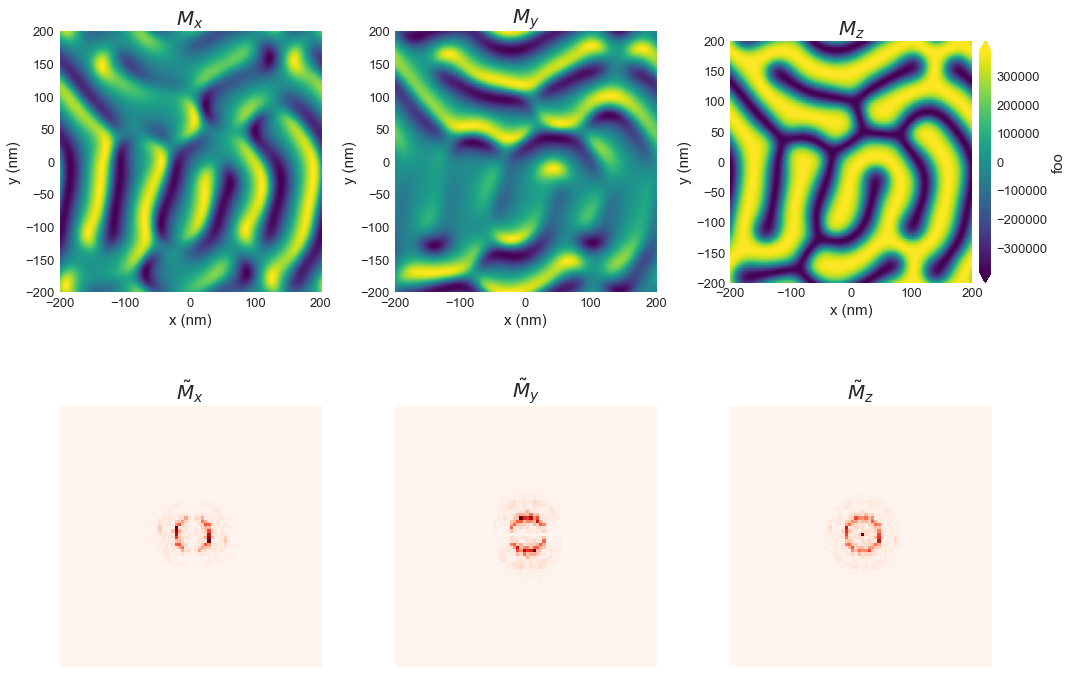

In [57]:
n = shape(system.m.array)[1]
mx = system.m.x.array.reshape(n,n)
my = system.m.y.array.reshape(n,n)
mz = system.m.z.array.reshape(n,n)

mxft = abs(fft2(mx))
mxft = fftshift(mxft)
myft = abs(fft2(my))
myft = fftshift(myft)
mzft = abs(fft2(mz))
mzft = fftshift(mzft)

fig, ax = subplots(2,3, figsize = [15,10])
ax[0,0].imshow(mx, origin='lower',extent= [-200,200,-200,200])
ax[0,0].set_xlabel('x (nm)')
ax[0,0].set_ylabel('y (nm)')
ax[0,0].set_title(r'$M_x$')

ax[0,1].imshow(my, origin='lower',extent= [-200,200,-200,200])
ax[0,1].set_xlabel('x (nm)')
ax[0,1].set_ylabel('y (nm)')
ax[0,1].set_title(r'$M_y$')

MZ=ax[0,2].imshow(mz, origin='lower',extent= [-200,200,-200,200])
ax[0,2].set_xlabel('x (nm)')
ax[0,2].set_ylabel('y (nm)')
ax[0,2].set_title(r'$M_z$')
#colorbar(MZ)
cb = colorbar(MZ, title='foo')

ax[1,0].imshow(mxft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
ax[1,0].set_xlim([-100,100])
ax[1,0].set_ylim([-100,100])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title(r'$\tilde{M}_x$')

ax[1,1].imshow(myft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
ax[1,1].set_xlim([-100,100])
ax[1,1].set_ylim([-100,100])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title(r'$\tilde{M}_y$')

mqz=ax[1,2].imshow(mzft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
ax[1,2].set_xlim([-100,100])
ax[1,2].set_ylim([-100,100])
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
ax[1,2].set_title(r'$\tilde{M}_z$')
#colorbar(mqz)

tight_layout()

# Calculate SANS

## Theory

Field $\bf{H}_0$ is in $\hat{z}$ direction. For perpendicular scattering geometry $\bf{k}_0 \perp \bf{H}_0$, $\theta$ is angle between $\bf{H}_0$ and momentum-transfer vector $\bf{q} = [0,q_y,q_z] = q[0, \sin\theta, \cos\theta]$. For parallel scattering geometry $\bf{k}_0 \parallel \bf{H}_0$, $\theta$ is angle between $\bf{H}_0$ and momentum-transfer vector $\bf{q} = [q_z,q_y,0] = q[\cos\theta, \sin\theta, 0]$.

Discrete atomic structure generally irrelevant for SANS. Magnetization can be represented as continuous magnetization field defined at each point in material. Magnetic SANS is consequence of nanoscale variations in orientation and magnitude of magnetization.

$$\tilde{\bf{M}}(\bf{q}) = [\tilde{M}_x(\bf{q}),\tilde{M}_y(\bf{q}),\tilde{M}_z(\bf{q})] = \frac{1}{(2\pi)^{3/2}}\int \bf{M}(\bf{r}) e^{-i\bf{q}\bf{r}} d\bf{r}$$

Define the Halpern-Johnson magnetic interaction vector:
$$ Q = \hat{q} \times \left(\hat{q} \times \tilde{M}(q)\right) = \hat{q}\left(\hat{q}\cdot \tilde{M}(q)\right) - \tilde{M}(q)$$
comes from dipolar nature of magnetic neutron scattering. Emphasizes that the only component of $M$ which is perpendicular to $q$ is relevant for magnetic scattering.

for $k_0 \perp H_0$ and $k_0 \parallel H_0$ we obtain:
\begin{align}
Q_\perp &= \begin{bmatrix}
        -\tilde{M}_x \\
        -\tilde{M}_y cos^2 \theta + \tilde{M}_z sin \theta cos\theta\\
        \tilde{M}_y sin\theta cos \theta - \tilde{M}_z sin^2 \theta\\\
    \end{bmatrix}
\\
\\
Q_\parallel &= \begin{bmatrix}
        -\tilde{M}_x sin^2 \theta + \tilde{M}_y sin \theta cos\theta \\
        \tilde{M}_x sin\theta cos \theta - \tilde{M}_y cos^2 \theta\\
        -\tilde{M}_z\\\
    \end{bmatrix}
\end{align}

Then the elastic non-spin-flip and spin-flip cross sections can be written as:
\begin{align}
\frac{d\Sigma^{\pm\pm}}{d\Omega} &~ |{\tilde{N}}| \pm \left(\tilde{N}Q^*_z + \tilde{N}Q_z\right) + |{Q_z}|^2\\
\frac{d\Sigma^{\pm\mp}}{d\Omega} &~ |Q_x|^2 + |Q_y|^2 \mp i\left(Q_xQ_y^*-Q_x^*Q_y\right)
\end{align}

For various SANS experiments, we can use these equations to get a cross section

Unpolarized SANS
\begin{align}
\frac{d\Sigma_\perp}{d\Omega} = K\left(b^{-2}|\tilde{N}|^2 + |\tilde{M}_x|^2+|\tilde{M}_y|^2cos^2\theta+|\tilde{M}_z|^2sin^2\theta-T_{yz}sin\theta cos\theta\right)
\end{align}
Where 
$$T_{yz} = \tilde{M}_y\tilde{M}_z^* +\tilde{M}_y^*\tilde{M}_z $$ 
and $b$, $\tilde{N}$ are parameters related to the neutron beam scattering

To summarize a little, the goal is to calculate the FT of the real space M field, which directly relates to the cross section.

## Calculation

### Helper Functions

In [9]:
def theta(x):
    # x is 2D array
    #creates matrix of angles in the same shape as input array
    x0, y0 = int(len(x)/2), int(len(x)/2)
    theta = zeros_like(x)
    for i in range(len(theta)):
        for j in range(len(theta)):
            theta[i][j] = arctan((i-y0)/ (j-x0+1e-6))
    return(theta)


In [11]:
def plotCross(field):
    n = shape(field.array)[1]
    mx = field.x.array.reshape(n,n)
    my = field.y.array.reshape(n,n)
    mz = field.z.array.reshape(n,n)

    mxft = abs(fft2(mx))
    mxft = fftshift(mxft)
    myft = abs(fft2(my))
    myft = fftshift(myft)
    mzft = abs(fft2(mz))
    mzft = fftshift(mzft)
    fig, ax = subplots(1,5, figsize= [25,5])
    ax[0].imshow(mxft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
    ax[0].set_xlim([-100,100])
    ax[0].set_ylim([-100,100])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(r'$\tilde{M}_x$')

    ax[1].imshow(myft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
    ax[1].set_xlim([-100,100])
    ax[1].set_ylim([-100,100])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title(r'$\tilde{M}_y$')

    ax[2].imshow(mzft, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
    ax[2].set_xlim([-100,100])
    ax[2].set_ylim([-100,100])
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title(r'$\tilde{M}_z$')
#cbarq = colorbar(mqz, ax = ax[1,2])
    T = fftshift(real(fft2(mz)*conj(fft2(my))+fft2(my)*conj(fft2(mz))))
    ax[3].imshow(abs(T), origin='lower',cmap='Reds',extent=[-200,200,-200,200])
    ax[3].set_xlim([-100,100])
    ax[3].set_ylim([-100,100])
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[3].set_title(r'$\tilde{T}_{yz}$')
    cross = mxft**2+myft**2*cos(theta(myft))**2+mzft**2*sin(theta(mzft))**2-T*sin(theta(T))*cos(theta(T))
    ax[4].imshow(cross, origin='lower',cmap='Reds',extent=[-200,200,-200,200])
    ax[4].set_xlim([-100,100])
    ax[4].set_ylim([-100,100])
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_title(r'$\frac{d\sigma}{d\Omega}$')
    tight_layout()

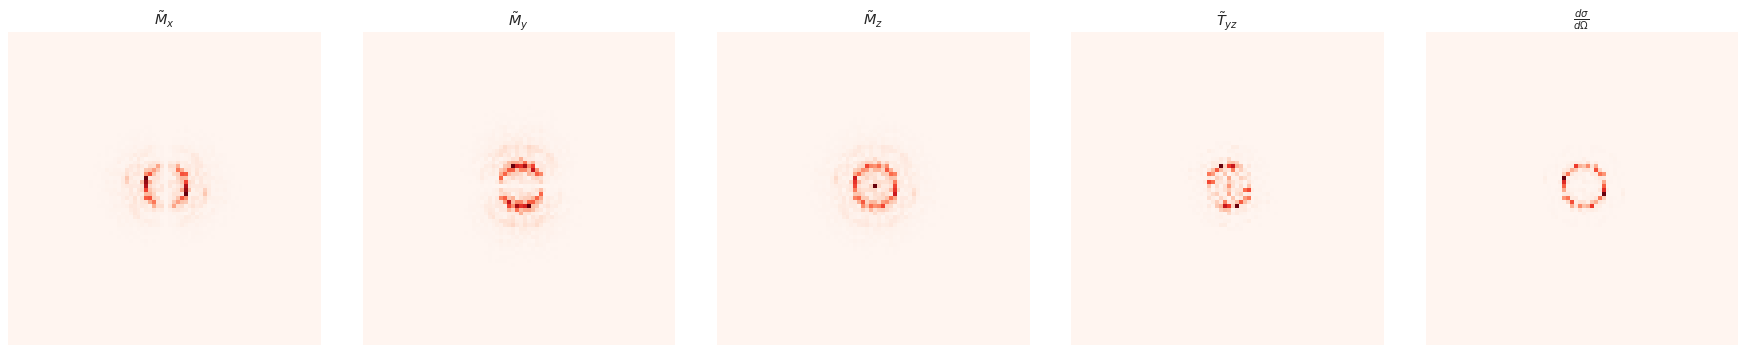

In [64]:
plotCross(system.m)
tight_layout()

In [17]:
def lineCut(a, phi, n=250, show=True):
    import scipy.ndimage
    phi = pi*phi/180
    # a is square 2D array, phi is scalar 
    r = int(len(a)/6)
    x0,y0 = int(len(a)/2), int(len(a)/2)
    x1,y1 = x0+r*cos(phi), x0+r*sin(phi)
    x, y = np.linspace(x0, x1, n), np.linspace(y0, y1, n)
    zi = scipy.ndimage.map_coordinates(a, np.vstack((x,y)))
    
    if show==True:
        fig, axes = subplots(1,2,figsize=[10,5])
        axes[0].imshow(a, origin='lower',cmap='Reds')
        axes[0].plot([x0, x1], [y0, y1])
        axes[0].set_xlim([40,120])
        axes[0].set_ylim([40,120])
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_title(r'$\frac{d\sigma}{d\Omega}$')
        axes[1].plot(zi)
        tight_layout()
    
    return(zi)



In [18]:
def linecutAvg(a, phi1, phi2, n=100, show=True):
    tot = []
    
    for phi in linspace(phi1,phi2,n):
        tot.append(lineCut(a, phi, show=False))
    tot = array(tot)
    r = int(len(a)/6)
    x0,y0 = int(len(a)/2), int(len(a)/2)
    x1_1,y1_1 = x0+r*cos(phi1*pi/180), x0+r*sin(phi1*pi/180)
    x1_2,y1_2 = x0+r*cos(phi2*pi/180), x0+r*sin(phi2*pi/180)
    if show ==True:
        fig, axes = subplots(1,2,figsize=[10,5])
        axes[0].imshow(a, origin='lower',cmap='Reds')
        axes[0].plot([x0, x1_1], [y0, y1_1],'g--')
        axes[0].plot([x0, x1_2], [y0, y1_2],'g--')
        axes[0].set_xlim([.25*len(a),.75*len(a)])
        axes[0].set_ylim([.25*len(a),.75*len(a)])
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_title(r'$\frac{d\sigma}{d\Omega}$')
        axes[1].plot(zi)
        tight_layout()
        
    return(mean(tot, axis=0))

In [66]:
cross = U.crossSection(system.m)

NameError: name 'zi' is not defined

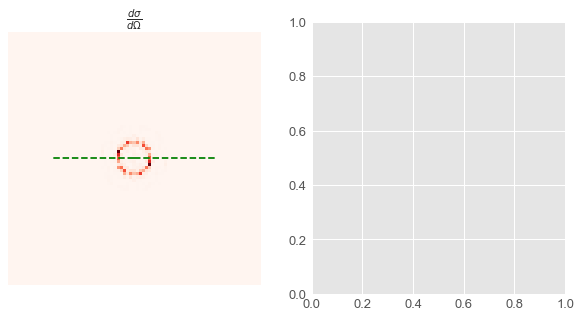

In [67]:
linecutAvg(cross, 0,180)

In [58]:
import UbermagSANS as U
plt.style.use('ggplot')

In [59]:
cross = U.crossSection(system.m)

In [62]:
%pylab inline
U.linecutAvg(cross, 0,180)
tight_layout()

Populating the interactive namespace from numpy and matplotlib


/Users/nathandrucker/opt/anaconda3/envs/ubermag/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['colorbar', 'cross']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


TypeError: object of type 'function' has no len()